In [1]:
# # from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')
!pwd

/kaggle/working


In [3]:

path = '/kaggle/working/run_'
# path=''

In [4]:
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from matplotlib import pyplot as plt
import copy
# from sparsemax import Sparsemax
import torch.optim as optim



# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
# n_seed = 0
#k = 0

In [5]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark= False

In [6]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)


testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


0it [00:00, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [7]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=10, shuffle=False)


classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

foreground_classes = {'plane', 'car', 'bird'}
#foreground_classes = {'bird', 'cat', 'deer'}
background_classes = {'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'}
#background_classes = {'plane', 'car', 'dog', 'frog', 'horse','ship', 'truck'}

fg1,fg2,fg3 = 0,1,2

In [8]:
dataiter = iter(trainloader)
background_data=[]
background_label=[]
foreground_data=[]
foreground_label=[]
batch_size=10

for i in range(5000):
  images, labels = dataiter.next()
  for j in range(batch_size):
    if(classes[labels[j]] in background_classes):
      img = images[j].tolist()
      background_data.append(img)
      background_label.append(labels[j])
    else:
      img = images[j].tolist()
      foreground_data.append(img)
      foreground_label.append(labels[j])
            
foreground_data = torch.tensor(foreground_data)
foreground_label = torch.tensor(foreground_label)
background_data = torch.tensor(background_data)
background_label = torch.tensor(background_label)

In [9]:
def create_mosaic_img(bg_idx,fg_idx,fg): 
  """
  bg_idx : list of indexes of background_data[] to be used as background images in mosaic
  fg_idx : index of image to be used as foreground image from foreground data
  fg : at what position/index foreground image has to be stored out of 0-8
  """
  image_list=[]
  j=0
  for i in range(9):
    if i != fg:
      image_list.append(background_data[bg_idx[j]])#.type("torch.DoubleTensor"))
      j+=1
    else: 
      image_list.append(foreground_data[fg_idx])#.type("torch.DoubleTensor"))
      label = foreground_label[fg_idx]- fg1  # minus fg1 because our fore ground classes are fg1,fg2,fg3 but we have to store it as 0,1,2
  #image_list = np.concatenate(image_list ,axis=0)
  image_list = torch.stack(image_list) 
  return image_list,label

In [10]:
desired_num = 30000
mosaic_list_of_images =[]      # list of mosaic images, each mosaic image is saved as list of 9 images
fore_idx =[]                   # list of indexes at which foreground image is present in a mosaic image i.e from 0 to 9               
mosaic_label=[]                # label of mosaic image = foreground class present in that mosaic
for i in range(desired_num):
  np.random.seed(i)
  bg_idx = np.random.randint(0,35000,8)
  fg_idx = np.random.randint(0,15000)
  fg = np.random.randint(0,9)
  fore_idx.append(fg)
  image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
  mosaic_list_of_images.append(image_list)
  mosaic_label.append(label)

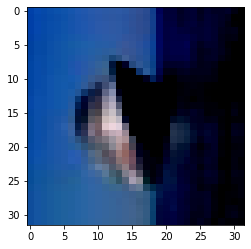

In [11]:
plt.imshow(torch.transpose(mosaic_list_of_images[0][1],dim0= 0,dim1 = 2))

In [12]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list_of_images, mosaic_label, fore_idx):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list_of_images
    self.label = mosaic_label
    self.fore_idx = fore_idx

  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx], self.fore_idx[idx]

batch = 250
msd = MosaicDataset(mosaic_list_of_images, mosaic_label , fore_idx)
train_loader = DataLoader( msd,batch_size= batch ,shuffle=True)

In [13]:
class Focus(nn.Module):
  def __init__(self):
    super(Focus, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=0,bias=False)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=0,bias=False)
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=0,bias=False)
    self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=0,bias=False)
    self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=0,bias=False)
    self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1,bias=False)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.batch_norm1 = nn.BatchNorm2d(32,track_running_stats=False)
    self.batch_norm2 = nn.BatchNorm2d(64,track_running_stats=False)
    self.batch_norm3 = nn.BatchNorm2d(256,track_running_stats=False)
    self.dropout1 = nn.Dropout2d(p=0.05)
    self.dropout2 = nn.Dropout2d(p=0.1)
    self.fc1 = nn.Linear(256,64,bias=False)
    self.fc2 = nn.Linear(64, 32,bias=False)
    self.fc3 = nn.Linear(32, 10,bias=False)
    self.fc4 = nn.Linear(10, 1,bias=False)
    
    torch.nn.init.xavier_normal_(self.conv1.weight)
    torch.nn.init.xavier_normal_(self.conv2.weight)
    torch.nn.init.xavier_normal_(self.conv3.weight)
    torch.nn.init.xavier_normal_(self.conv4.weight)
    torch.nn.init.xavier_normal_(self.conv5.weight)
    torch.nn.init.xavier_normal_(self.conv6.weight)

    torch.nn.init.xavier_normal_(self.fc1.weight)
    torch.nn.init.xavier_normal_(self.fc2.weight)
    torch.nn.init.xavier_normal_(self.fc3.weight)
    torch.nn.init.xavier_normal_(self.fc4.weight)


  def forward(self,z):  #y is avg image #z batch of list of 9 images
    y = torch.zeros([batch,3, 32,32], dtype=torch.float64)
    x = torch.zeros([batch,9],dtype=torch.float64)
    #ftr = torch.zeros([batch,9,3,32,32])
    y = y.to("cuda")
    x = x.to("cuda")
    #ftr = ftr.to("cuda")
    
    for i in range(9):
        out = self.helper(z[:,i])
        #print(out.shape)
        x[:,i] = out[:,0]
        #ftr[:,i] = ftrs
    log_x = F.log_softmax(x,dim=1)
    x = F.softmax(x,dim=1)

    for i in range(9):            
      x1 = x[:,i]          
      y = y + torch.mul(x1[:,None,None,None],z[:,i])

    return x, y,log_x #alpha,avg_data
    
  def helper(self, x):
    #x1 = x
    #x1 =x
    x = self.conv1(x)
    x = F.relu(self.batch_norm1(x))

    x = (F.relu(self.conv2(x)))
    x = self.pool(x)
    
    x = self.conv3(x)
    x = F.relu(self.batch_norm2(x))

    x = (F.relu(self.conv4(x)))
    x = self.pool(x)
    x = self.dropout1(x)

    x = self.conv5(x)
    
    x = F.relu(self.batch_norm3(x))

    x = self.conv6(x)
    
    x = F.relu(x)
    x = self.pool(x)

    x = x.view(x.size(0), -1)

    x = self.dropout2(x)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.dropout2(x)
    x = F.relu(self.fc3(x))
    x = self.fc4(x)
    return x

In [14]:
class Classification(nn.Module):
  def __init__(self):
    super(Classification, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
    self.conv4 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
    self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
    self.conv6 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2,padding=1)
    self.batch_norm1 = nn.BatchNorm2d(128,track_running_stats=False)
    self.batch_norm2 = nn.BatchNorm2d(256,track_running_stats=False)
    self.batch_norm3 = nn.BatchNorm2d(512,track_running_stats=False)
    self.dropout1 = nn.Dropout2d(p=0.05)
    self.dropout2 = nn.Dropout2d(p=0.1)
    self.global_average_pooling = nn.AvgPool2d(kernel_size=4)
    self.fc1 = nn.Linear(512,128)
    # self.fc2 = nn.Linear(128, 64)
    # self.fc3 = nn.Linear(64, 10)
    self.fc2 = nn.Linear(128, 3)


    torch.nn.init.xavier_normal_(self.conv1.weight)
    torch.nn.init.xavier_normal_(self.conv2.weight)
    torch.nn.init.xavier_normal_(self.conv3.weight)
    torch.nn.init.xavier_normal_(self.conv4.weight)
    torch.nn.init.xavier_normal_(self.conv5.weight)
    torch.nn.init.xavier_normal_(self.conv6.weight)

    torch.nn.init.zeros_(self.conv1.bias)
    torch.nn.init.zeros_(self.conv2.bias)
    torch.nn.init.zeros_(self.conv3.bias)
    torch.nn.init.zeros_(self.conv4.bias)
    torch.nn.init.zeros_(self.conv5.bias)
    torch.nn.init.zeros_(self.conv6.bias)


    torch.nn.init.xavier_normal_(self.fc1.weight)
    torch.nn.init.xavier_normal_(self.fc2.weight)
    torch.nn.init.zeros_(self.fc1.bias)
    torch.nn.init.zeros_(self.fc2.bias)


  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(self.batch_norm1(x))

    x = (F.relu(self.conv2(x)))
    x = self.pool(x)
    
    x = self.conv3(x)
    x = F.relu(self.batch_norm2(x))

    x = (F.relu(self.conv4(x)))
    x = self.pool(x)
    x = self.dropout1(x)

    x = self.conv5(x)
    x = F.relu(self.batch_norm3(x))

    x = (F.relu(self.conv6(x)))
    x = self.pool(x)
    #print(x.shape)
    x = self.global_average_pooling(x)
    x = x.squeeze()
    #x = x.view(x.size(0), -1)
    #print(x.shape)
    x = self.dropout2(x)
    x = F.relu(self.fc1(x))
    #x = F.relu(self.fc2(x))
    #x = self.dropout2(x)
    #x = F.relu(self.fc3(x))
    x = self.fc2(x)
    return x

In [15]:
test_images =[]        #list of mosaic images, each mosaic image is saved as laist of 9 images
fore_idx_test =[]                   #list of indexes at which foreground image is present in a mosaic image                
test_label=[]                # label of mosaic image = foreground class present in that mosaic
for i in range(10000):
  np.random.seed(i+30000)
  bg_idx = np.random.randint(0,35000,8)
  fg_idx = np.random.randint(0,15000)
  fg = np.random.randint(0,9)
  fore_idx_test.append(fg)
  image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
  test_images.append(image_list)
  test_label.append(label)

In [16]:
test_data = MosaicDataset(test_images,test_label,fore_idx_test)
test_loader = DataLoader( test_data,batch_size= batch ,shuffle=False)

In [17]:
criterion = nn.CrossEntropyLoss()
def my_cross_entropy(x, y,alpha,log_alpha,k):
    # log_prob = -1.0 * F.log_softmax(x, 1)
    # loss = log_prob.gather(1, y.unsqueeze(1))
    # loss = loss.mean()
    loss = criterion(x,y)
    
    #alpha = torch.clamp(alpha,min=1e-10)     
    
    b = -1.0* alpha * log_alpha
    b =  torch.mean(torch.sum(b,dim=1))
    closs = loss
    entropy = b 
    loss = (1-k)*loss + ((k)*b)
    return loss,closs,entropy

In [18]:
def calculate_attn_loss(dataloader,what,where,k):
    what.eval()
    where.eval()
    r_loss = 0
    alphas = []
    lbls = []
    pred = []
    fidices = []
    with torch.no_grad():
        for i, data in enumerate(dataloader, 0):
            inputs, labels,fidx = data
            lbls.append(labels)
            fidices.append(fidx)
            inputs = inputs.double()
            inputs, labels = inputs.to("cuda"),labels.to("cuda")



            alpha, avg_images,log_alphas = focus_net(inputs)
            outputs = classify(avg_images)
      
      
            _, predicted = torch.max(outputs.data, 1)
            pred.append(predicted.cpu().numpy())
            alphas.append(alpha.cpu().numpy())

            loss,_,_ = my_cross_entropy(outputs, labels, alpha, log_alphas, k)
            r_loss += loss.item()


    alphas = np.concatenate(alphas,axis=0)
    pred = np.concatenate(pred,axis=0)
    lbls = np.concatenate(lbls,axis=0)
    fidices = np.concatenate(fidices,axis=0)
    #print(alphas.shape,pred.shape,lbls.shape,fidices.shape) 
    
    # value>0.01
    sparsity_val = np.sum(np.sum(alphas>0.01,axis=1))
    
    
    # simplex distance
    argmax_index = np.argmax(alphas,axis=1)
    simplex_pt = np.zeros(alphas.shape)
    simplex_pt[np.arange(argmax_index.size),argmax_index] = 1
    
    shortest_distance_simplex = np.sum(np.sqrt(np.sum((alphas-simplex_pt)**2,axis=1))) 
    
    # entropy
    entropy = np.sum((-alphas*np.log2(alphas)).sum(axis=1))
    
    
    
    
    
    
    
    analysis = analyse_data(alphas,lbls,pred,fidices)
    return analysis,[sparsity_val,shortest_distance_simplex ,entropy]

In [19]:
def analyse_data(alphas,lbls,predicted,f_idx):
    '''
       analysis data is created here
    '''
    batch = len(predicted)
    amth,alth,ftpt,ffpt,ftpf,ffpf = 0,0,0,0,0,0
    for j in range (batch):
        focus = np.argmax(alphas[j])
        if(alphas[j][focus] >= 0.5):
            amth +=1
        else:
            alth +=1
        if(focus == f_idx[j] and predicted[j] == lbls[j]):
            ftpt += 1
        elif(focus != f_idx[j] and predicted[j] == lbls[j]):
            ffpt +=1
        elif(focus == f_idx[j] and predicted[j] != lbls[j]):
            ftpf +=1
        elif(focus != f_idx[j] and predicted[j] != lbls[j]):
            ffpf +=1

    return [ftpt,ffpt,ftpf,ffpf,amth,alth]

In [20]:
n_seed =[0, 1, 2]
lr = [0.0005, 0.001]
k = 0

In [21]:
Analysis_ = {}
Train_Loss_ = []

for n_seed_ in n_seed:
    for lr_ in lr:
        analyse_data_train = []
        analyse_data_test = []
        sparsty_train = []
        sparsty_test = []
        
        tr_loss = []
        
        print("initializing models using seed",n_seed_)
        torch.manual_seed(n_seed_)
        focus_net = Focus().double()
        focus_net = focus_net.to("cuda")


        torch.manual_seed(n_seed_)
        classify = Classification().double()
        classify = classify.to("cuda")


        criterion = nn.CrossEntropyLoss()


        print("using lr",lr_)

        optimizer_focus = optim.Adam(focus_net.parameters(), lr=lr_)#, momentum=0.9)
        optimizer_classify = optim.Adam(classify.parameters(), lr=lr_)#, momentum=0.9)
        
        analysis_data_train, sparsity_value_train =calculate_attn_loss(train_loader,classify,focus_net,k)
        
        analysis_data_test, sparsity_value_test =calculate_attn_loss(test_loader,classify,focus_net,k)
        
        analyse_data_train.append(analysis_data_train)
        analyse_data_test.append(analysis_data_test)
        sparsty_train.append(sparsity_value_train)
        sparsty_test.append(sparsity_value_test)
        
        nos_epochs = 70
        
        
        focus_net.train()
        classify.train()
        
        for epoch in range(nos_epochs):  # loop over the dataset multiple time
            focus_net.train()
            classify.train()
            
            epoch_loss = []
            cnt=0
            running_loss = 0
            
            iteration = desired_num // batch
            for i, data in  enumerate(train_loader):
                inputs , labels , fore_idx = data
                inputs = inputs.double()
                inputs, labels = inputs.to("cuda"), labels.to("cuda")
                
                # zero the parameter gradients
                optimizer_focus.zero_grad()
                optimizer_classify.zero_grad()
            
                alphas, avg_images,log_alphas = focus_net(inputs)
                outputs = classify(avg_images)

                # outputs, alphas, avg_images = classify(inputs)

                _, predicted = torch.max(outputs.data, 1)
                
                loss,_,_ = my_cross_entropy(outputs, labels,alphas,log_alphas,k)
                loss.backward()
                optimizer_focus.step()
                optimizer_classify.step()

                running_loss += loss.item()
                mini = 60
                if cnt % mini == mini-1:    # print every 60 mini-batches
                    print('[%d, %5d] loss: %.3f' %(epoch + 1, cnt + 1, running_loss / mini))
                    epoch_loss.append(running_loss/mini)
                    running_loss = 0.0
                cnt=cnt+1
                
            tr_loss.append(np.mean(epoch_loss))
                
            if epoch % 1 == 0:
                analysis_data_train, sparsity_value_train = calculate_attn_loss(train_loader,classify,focus_net,k)
        
                analysis_data_test, sparsity_value_test = calculate_attn_loss(test_loader,classify,focus_net,k)    
                
                analyse_data_train.append(analysis_data_train)
                analyse_data_test.append(analysis_data_test)
                sparsty_train.append(sparsity_value_train)
                sparsty_test.append(sparsity_value_test)
            if(np.mean(epoch_loss) <= 0.05):
                break
        print('Finished Training') 
        print("train FTPT Analysis and sparsity values",analysis_data_train,sparsity_value_train)
        print("test FTPT Analysis and sparsity values",analysis_data_test,sparsity_value_test)
        
        torch.save(focus_net.state_dict(),path+"seed_"+str(n_seed_)+"lr_"+str(lr_)+"weights_focus.pt")  
        torch.save(classify.state_dict(),path+"seed_"+str(n_seed_)+"lr_"+str(lr_)+"weights_classify.pt")
         
        Analysis_["train_seed_"+str(n_seed_)+"_lr_"+str(lr_)] = np.array(analyse_data_train)
        Analysis_["test_seed_"+str(n_seed_)+"_lr_"+str(lr_)]  = np.array(analyse_data_test)
        Analysis_["train_sparsity_"+str(n_seed_)+"_lr_"+str(lr_)] = np.array(sparsty_train)
        Analysis_["test_sparsity_"+str(n_seed_)+"_lr_"+str(lr_)] = np.array(sparsty_test)
        
        Train_Loss_.append(tr_loss)

initializing models using seed 0
using lr 0.0005
[1,    60] loss: 1.211
[1,   120] loss: 1.028
[2,    60] loss: 0.939
[2,   120] loss: 0.832
[3,    60] loss: 0.728
[3,   120] loss: 0.675
[4,    60] loss: 0.573
[4,   120] loss: 0.545
[5,    60] loss: 0.472
[5,   120] loss: 0.453
[6,    60] loss: 0.386
[6,   120] loss: 0.387
[7,    60] loss: 0.332
[7,   120] loss: 0.343
[8,    60] loss: 0.292
[8,   120] loss: 0.294
[9,    60] loss: 0.250
[9,   120] loss: 0.266
[10,    60] loss: 0.220
[10,   120] loss: 0.228
[11,    60] loss: 0.209
[11,   120] loss: 0.212
[12,    60] loss: 0.175
[12,   120] loss: 0.180
[13,    60] loss: 0.171
[13,   120] loss: 0.161
[14,    60] loss: 0.149
[14,   120] loss: 0.153
[15,    60] loss: 0.136
[15,   120] loss: 0.142
[16,    60] loss: 0.121
[16,   120] loss: 0.140
[17,    60] loss: 0.112
[17,   120] loss: 0.115
[18,    60] loss: 0.108
[18,   120] loss: 0.103
[19,    60] loss: 0.098
[19,   120] loss: 0.100
[20,    60] loss: 0.076
[20,   120] loss: 0.096
[21,    6

In [22]:
np.save("analysis.npy",Analysis_)
np.save("training_loss.npy",Train_Loss_)

In [23]:
Analysis_

{'train_seed_0_lr_0.0005': array([[  399,  9739,  1607, 18255,     0, 30000],
        [ 8376,  7681,  2998, 10945, 10526, 19474],
        [13528,  6567,  3081,  6824, 11410, 18590],
        [16628,  5940,  2896,  4536, 17382, 12618],
        [17999,  6184,  2355,  3462, 17895, 12105],
        [20003,  5667,  1787,  2543, 20733,  9267],
        [20777,  5576,  1577,  2070, 18314, 11686],
        [21660,  5304,  1362,  1674, 20303,  9697],
        [22176,  5397,  1123,  1304, 21108,  8892],
        [23321,  4797,   728,  1154, 22546,  7454],
        [23495,  4895,   642,   968, 22115,  7885],
        [23395,  4926,   572,  1107, 23665,  6335],
        [23728,  4840,   476,   956, 23050,  6950],
        [23878,  4885,   456,   781, 22765,  7235],
        [24372,  4633,   339,   656, 23464,  6536],
        [24355,  4650,   401,   594, 23114,  6886],
        [24661,  4428,   342,   569, 23334,  6666],
        [24733,  4538,   248,   481, 23599,  6401],
        [24759,  4452,   186,   603, 2

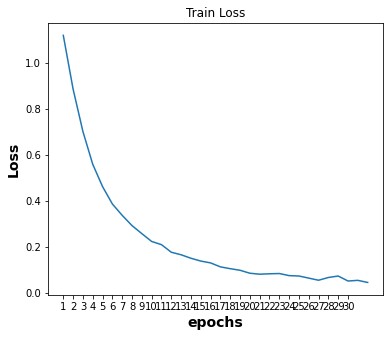

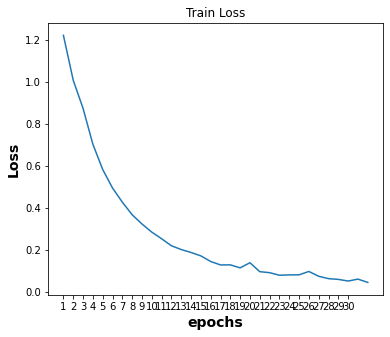

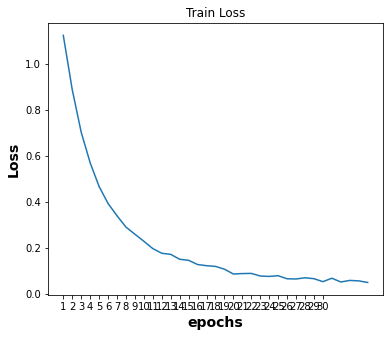

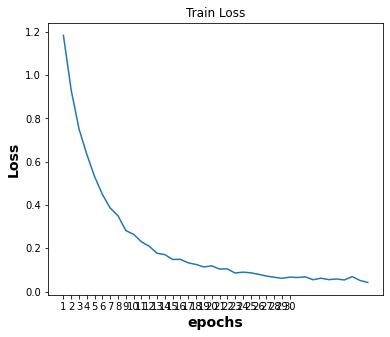

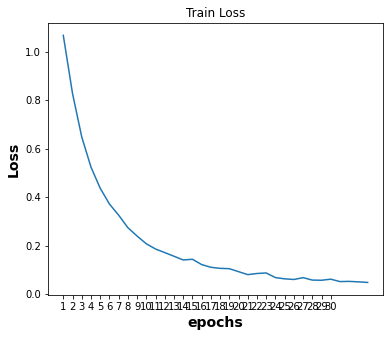

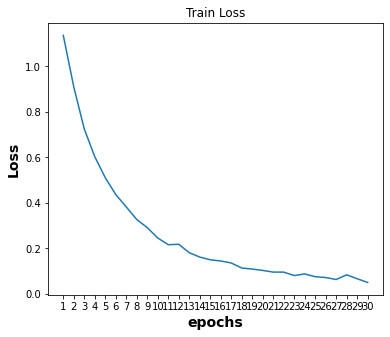

In [24]:
for i in range(len(Train_Loss_)):
    plt.figure(figsize=(6,5))
    plt.plot(np.arange(1,len(Train_Loss_[i])+1),Train_Loss_[i])
    plt.xlabel("epochs", fontsize=14, fontweight = 'bold')
    plt.ylabel("Loss", fontsize=14, fontweight = 'bold')
    plt.xticks(np.arange(1,epoch+2))
    plt.title("Train Loss")
    # #plt.grid()
    plt.show()

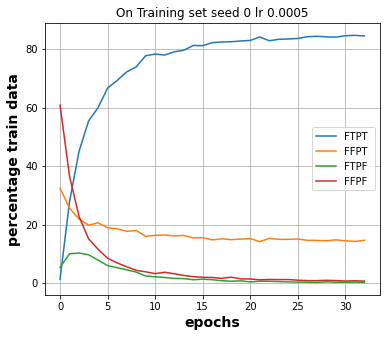

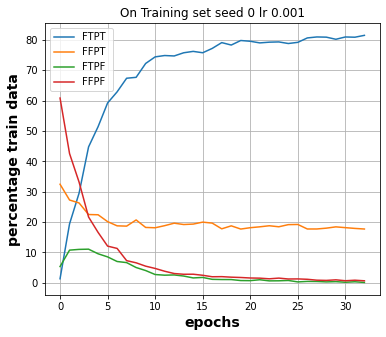

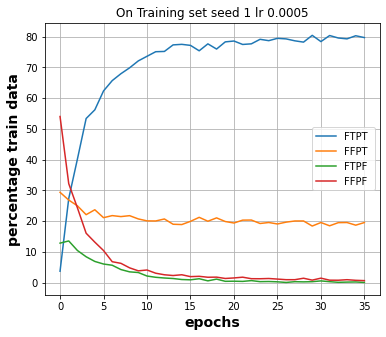

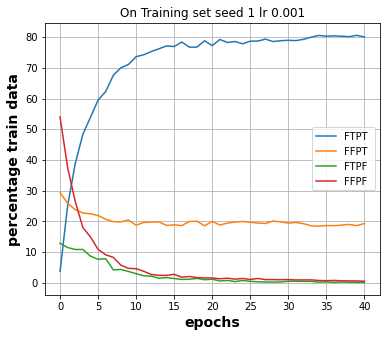

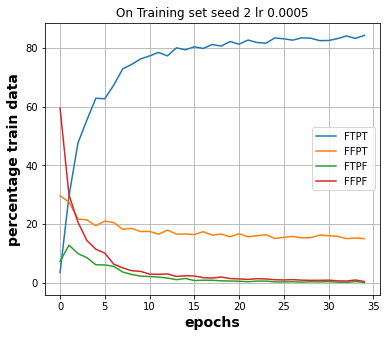

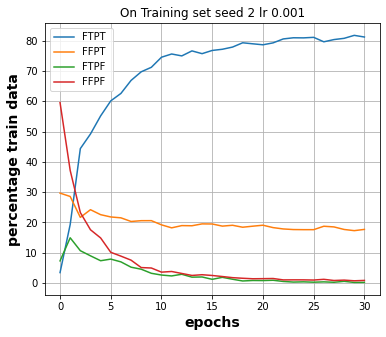

In [25]:
for seed_ in n_seed:
    for lr_ in lr:
        data = Analysis_['train_seed_'+ str(seed_)+"_lr_" +str(lr_)]
        plt.figure(figsize=(6,5))
        plt.plot(np.arange(0,len(data)),data[:,0]/300, label ="FTPT ")
        plt.plot(np.arange(0,len(data)),data[:,1]/300, label ="FFPT ")
        plt.plot(np.arange(0,len(data)),data[:,2]/300, label ="FTPF ")
        plt.plot(np.arange(0,len(data)),data[:,3]/300, label ="FFPF ")
        plt.title("On Training set " + 'seed ' + str(seed_)+" lr " +str(lr_))
        #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.xlabel("epochs", fontsize=14, fontweight = 'bold')
        plt.ylabel("percentage train data", fontsize=14, fontweight = 'bold')
        # plt.xlabel("epochs")
        # plt.ylabel("training data")
        plt.legend()

        plt.savefig(path + 'seed ' + str(seed_)+" lr " +str(lr_)+ "_train.png",bbox_inches="tight")
        plt.savefig(path + 'seed ' + str(seed_)+" lr " +str(lr_)+ "_train.pdf",bbox_inches="tight")
        plt.grid()
        plt.show()

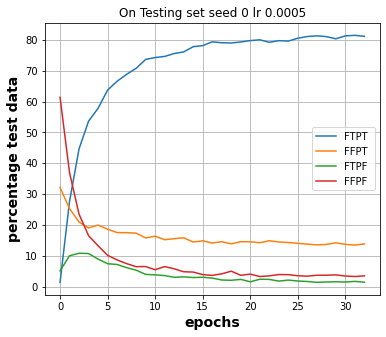

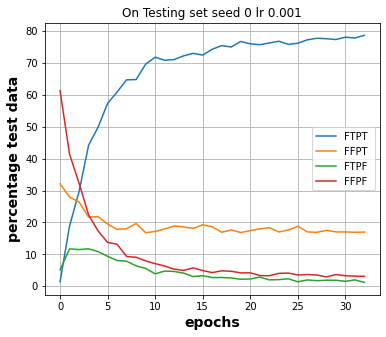

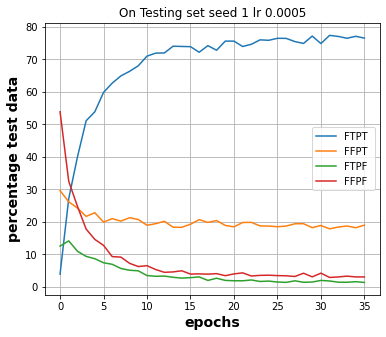

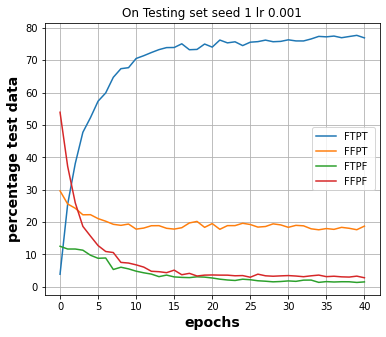

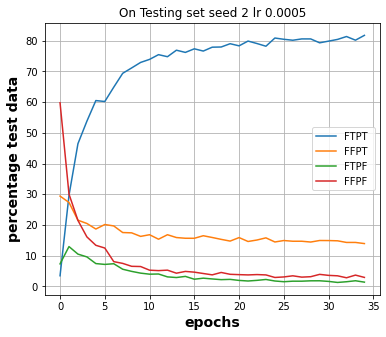

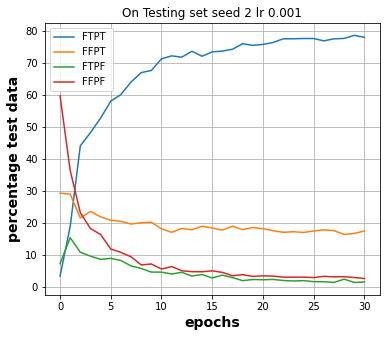

In [26]:
for seed_ in n_seed:
    for lr_ in lr:
        data = Analysis_['test_seed_'+ str(seed_)+"_lr_" +str(lr_)]
        plt.figure(figsize=(6,5))
        plt.plot(np.arange(0,len(data)),data[:,0]/100, label ="FTPT ")
        plt.plot(np.arange(0,len(data)),data[:,1]/100, label ="FFPT ")
        plt.plot(np.arange(0,len(data)),data[:,2]/100, label ="FTPF ")
        plt.plot(np.arange(0,len(data)),data[:,3]/100, label ="FFPF ")
        plt.title("On Testing set " + 'seed ' + str(seed_)+" lr " +str(lr_))
        #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.xlabel("epochs", fontsize=14, fontweight = 'bold')
        plt.ylabel("percentage test data", fontsize=14, fontweight = 'bold')
        # plt.xlabel("epochs")
        # plt.ylabel("training data")
        plt.legend()

        plt.savefig(path + 'seed ' + str(seed_)+" lr " +str(lr_)+"_test.png",bbox_inches="tight")
        plt.savefig(path + 'seed ' + str(seed_)+" lr " +str(lr_)+ "_test.pdf",bbox_inches="tight")
        plt.grid()
        plt.show()